
**TOV Stars with Piecewise Polytropic equation of state**

N. Stergioulas

Aristotle University of Thessaloniki

v1.0 (June 2018)

###### Content provided under a Creative Commons Attribution license, [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/); code under [GNU GPLv3 License](https://choosealicense.com/licenses/gpl-3.0/). (c)2018 [Nikolaos Stergioulas](http://www.astro.auth.gr/~niksterg/)


In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
from scipy import integrate
from scipy import optimize
from scipy.interpolate import PchipInterpolator
import sys
from decimal import Decimal
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from IPython.display import Image

# The TOV equations for spherical stars

Consider the metric for a spherically symmetric, stationary and asymptotic spacetime in Schwarzshild coordinates $t, r, \theta, \phi$
$$ ds^2 = -e^{\nu}dt^2 +e^{\lambda}dr^2 + r^2(d\theta^2+\sin^2\theta d\phi^2)$$
The TOV system in units $c=G=1$ is
$$ P = P(\epsilon),$$
$$ \frac{dP}{dr} = -\frac{(\epsilon+P)(m+4\pi r^3P)}{r(r-2m)},$$
$$ \frac{dm}{dr} = 4\pi r^2 \epsilon$$
$$ \frac{d\nu}{dr} = -\frac{2}{\epsilon+P}\frac{dP}{dr}=\frac{2(m+4\pi r^3P)}{r(r-2m)},$$
$$ \lambda = -\ln\left(1-\frac{2m}{r}\right),$$
The central values are
$$ P(0) = P_c,$$
$$ m(0) = 0,$$
$$ \nu(0) = -1.$$
where the last choice is arbitrary (after the interior solution is obtained, $\nu$ will be shifted to match the Schwarzschild exterior solution at the surface).

Near the center, we do a series expansion 
$$P(r) \simeq P_c -(2\pi)(\epsilon_c+P_c) \left( P_c+\frac{1}{3}\epsilon_c \right) r^2 + O(r^4),$$
$$ m(r) \simeq \frac{4}{3}\pi\epsilon_cr^3 + O(r^4),$$
$$ \nu(r) \simeq \nu_c + 4\pi \left(P_c+ \frac{1}{3}\epsilon_c \right)r^2 + O(r^4).$$
The value of $\nu$ at the surface is 
$$ \nu_\star = -\lambda_\star = \ln\left(1-\frac{2M}{R}\right).$$
The gravitational mass can be obtained as 
$$ M = \int_0^R 4\pi r^2\epsilon dr,$$
or as
$$ M = \int_0^R 4\pi r^2 e^{(\nu+\lambda)/2}(\epsilon +3P)dr,$$
The baryon mass of the star is
$$ M_0 = \int_0^R 4\pi r^2 e^{\lambda/2}\rho dr. $$


# Piecewise Polytropic equation of state

Following [Read et al 2009](https://ui.adsabs.harvard.edu/#abs/2009PhRvD..79l4033R/abstract) a piecewise polytropic EOS is defined by a low-density $\rho <\rho_0$ part (which can be a tabulated crust EOS or its piecewise polytropic analytic approximation) and a high-density part, $\rho \geq \rho_0$. The matching density $\rho_0$ is defined by the crossing point between the low-density part and the first high-density piece. The other two dividing densities in the high-density region are fixed as $\rho_1 = 10^{14.7}{\rm g/cm^3}$ and  $\rho_2= 10^{15.0}{\rm g/cm^3}$.

The pressure and density satisfy in each density interval $\rho_{i-1} \leq \rho \leq \rho_i$ the polytropic relation: 
$$P = K_i\rho^{\Gamma_i}$$
are are required to be everywhere continuous. This means that at a dividing density $\rho_i$
$$P(\rho_i) = K_i\rho^{\Gamma_i} = K_{i+1}\rho^{\Gamma_{i+1}}$$
which determines $K_2$ and $K_3$ for chosen $K_1, \Gamma_1, \Gamma_2, \Gamma_3$ (equivalently, for given $p_1, \Gamma_2, \Gamma_3$).

Integrating the first law of thermodynamics for barotropic fluids
$$ d\frac{\epsilon}{\rho} = - P d\frac{1}{\rho}$$
and requiring continuity in the energy density, yields:
$$\epsilon(\rho) = (1+\alpha_i)\rho + \frac{K_i}{\Gamma_i-1}\rho^{\Gamma_i}$$
(as long as $\Gamma_i \neq 1$),where
$$\alpha_i = \frac{\epsilon(\rho_{i-1})}{\rho_{i-1}} -1 - \frac{K_i}{\Gamma_i-1}\rho_{i-1}^{\Gamma_i-1}$$
Furthermore, the specific enthalpy $h:=(\epsilon+P)/\rho$, velocity of sound $v_s =\sqrt{dP/d\epsilon}$ and internal energy $e:=\epsilon/\rho-1$ are:
$$h(\rho) = 1+a_i + \frac{\Gamma_i}{\Gamma_i-1}K_i\rho^{\Gamma_i}$$
$$v_s(\rho) = \sqrt{\frac{\Gamma_i P}{\epsilon+P}}$$
$$ e(\rho) = \alpha_i + \frac{K_i}{\Gamma_i-1}\rho^{\Gamma_i-1}$$

In the numerical implementation, we use a length scale of $M_\odot =1$. For the output, units are also converted to CGS.

<img src="pp-eos.png" alt="drawing" width="400px"/>


# Numerical implementation

## Define the equation of state

In [3]:
c=2.9979e10
G=6.67408e-8
Msun=1.989e33
Length = G*Msun/c**2
Time = Length/c
Density = Msun/Length**3

Define the dividing densities for the high-density part

In [4]:
rho1 = pow(10,14.7)/Density
rho2 = pow(10,15.0)/Density

Set $p_1, \Gamma_1, \Gamma_2, \Gamma_3$ for EOS

In [5]:
#SLy
p1 = pow(10.0,34.384)/Density/c**2
Gamma1 = 3.005
Gamma2 = 2.988
Gamma3 = 2.851

Find $K_1, K_2, K_3$

In [6]:
K1 = p1 / pow(rho1,Gamma1)
K2 = K1 * pow( rho1, Gamma1-Gamma2)
K3 = K2 * pow( rho2, Gamma2-Gamma3)

Low-density part (PP approximation to low-density SLy EOS in [Read et al 2009](https://ui.adsabs.harvard.edu/#abs/2009PhRvD..79l4033R/abstract))

In [7]:
rhoL_1 = 2.62789e12/Density
rhoL_2 = 3.78358e11/Density
rhoL_3 = 2.44034e7/Density
rhoL_4 = 0.0
#display(rhoL_1,rhoL_2,rhoL_3,rhoL_4)

In [8]:
GammaL_1 = 1.35692
GammaL_2 = 0.62223
GammaL_3 = 1.28733
GammaL_4 = 1.58425

In [9]:
KL_1 = 3.99874e-8 * pow(Msun/Length**3, GammaL_1-1)  # notice a missing c^2 in Ki values in Table II of Read et al. 2009
KL_2 = 5.32697e+1 * pow(Msun/Length**3, GammaL_2-1) 
KL_3 = 1.06186e-6 * pow(Msun/Length**3, GammaL_3-1)  
KL_4 = 6.80110e-9 * pow(Msun/Length**3, GammaL_4-1)  
#display(KL_1, KL_2, KL_3, KL_4)

In [10]:
epsL_4 = 0.0
alphaL_4 = 0.0
epsL_3 = (1+alphaL_4)*rhoL_3 + KL_4/(GammaL_4 - 1)*pow(rhoL_3, GammaL_4)
alphaL_3 = epsL_3/rhoL_3 - 1 - KL_3/(GammaL_3 - 1)*pow(rhoL_3, GammaL_3 -1)
epsL_2 = (1+alphaL_3)*rhoL_2 + KL_3/(GammaL_3 - 1)*pow(rhoL_2, GammaL_3)
alphaL_2 = epsL_2/rhoL_2 - 1 - KL_2/(GammaL_2 - 1)*pow(rhoL_2, GammaL_2 -1)
epsL_1 = (1+alphaL_2)*rhoL_1 + KL_2/(GammaL_2 - 1)*pow(rhoL_1, GammaL_2)
alphaL_1 = epsL_1/rhoL_1 - 1 - KL_1/(GammaL_1 - 1)*pow(rhoL_1, GammaL_1 -1)

In [11]:
rho0 = pow(KL_1/K1,1.0/(Gamma1-GammaL_1))
eps0 = (1.0+alphaL_1)*rho0 + KL_1/(GammaL_1-1.0)*pow(rho0,GammaL_1)

In [12]:
alpha1 = eps0/rho0 - 1 - K1/(Gamma1 - 1)*pow(rho0, Gamma1 -1)
eps1 = (1+alpha1)*rho1 + K1/(Gamma1 - 1)*pow(rho1, Gamma1)
alpha2 = eps1/rho1 - 1 - K2/(Gamma2 - 1)*pow(rho1, Gamma2 -1)
eps2 = (1+alpha2)*rho2 + K2/(Gamma2 - 1)*pow(rho2, Gamma2)
alpha3 = eps2/rho2 - 1 - K3/(Gamma3 - 1)*pow(rho2, Gamma3 -1)

In [13]:
args = (rhoL_3,rhoL_2,rhoL_1,rho0,rho1,rho2,KL_4,KL_3,KL_2,KL_1,K1,K2,K3,GammaL_4,GammaL_3,GammaL_2,GammaL_1,Gamma1,Gamma2,Gamma3)

In [14]:
def P_of_rho(rho, args):
    rhoL_3,rhoL_2,rhoL_1,rho0,rho1,rho2,KL_4,KL_3,KL_2,\
    KL_1,K1,K2,K3,GammaL_4,GammaL_3,GammaL_2,GammaL_1,Gamma1,Gamma2,Gamma3 = args
    if rho<rhoL_3:
        return KL_4*pow(rho,GammaL_4)
    elif rhoL_3<= rho <rhoL_2:
        return KL_3*pow(rho,GammaL_3)
    elif rhoL_2<= rho <rhoL_1:
        return KL_2*pow(rho,GammaL_2)
    elif rhoL_1<= rho <rho0:
        return KL_1*pow(rho,GammaL_1)
    elif rho0<= rho <rho1:
        return K1*pow(rho,Gamma1)
    elif rho1<= rho <rho2:
        return K2*pow(rho,Gamma2)
    else:
        return K3*pow(rho,Gamma3)

In [15]:
def rho_of_P(p, args):
    rhoL_3,rhoL_2,rhoL_1,rho0,rho1,rho2,KL_4,KL_3,KL_2,\
    KL_1,K1,K2,K3,GammaL_4,GammaL_3,GammaL_2,GammaL_1,Gamma1,Gamma2,Gamma3 = args
    if p<pL_3:
        return pow(p/KL_4, 1.0/GammaL_4)
    elif pL_3<= p <pL_2:
        return pow(p/KL_3, 1.0/GammaL_3)
    elif pL_2<= p <pL_1:
        return pow(p/KL_2, 1.0/GammaL_2)
    elif pL_1<= p <p0:
        return pow(p/KL_1, 1.0/GammaL_1)
    elif p0<= p <p1:
        return pow(p/K1, 1.0/Gamma1)
    elif p1<= p <p2:
        return pow(p/K2, 1.0/Gamma2)
    else:
        return pow(p/K3, 1.0/Gamma3)

In [16]:
pL_3 = KL_3*pow(rhoL_3,GammaL_3)
pL_2 = KL_2*pow(rhoL_2,GammaL_2)
pL_1 = KL_1*pow(rhoL_1,GammaL_1)
p0 = KL_1*pow(rho0,GammaL_1)
p2 = K2*pow(rho2,Gamma2)
args2 = (rhoL_3,rhoL_2,rhoL_1,rho0,rho1,rho2,KL_4,KL_3,KL_2,KL_1,K1,K2,K3,\
        GammaL_4,GammaL_3,GammaL_2,GammaL_1,Gamma1,Gamma2,Gamma3,\
        pL_3,pL_2, pL_1, p0, p1, p2,\
        alphaL_4, alphaL_3, alphaL_2, alphaL_1, alpha1, alpha2, alpha3)

In [17]:
def eps_of_rho(rho, args2):
    rhoL_3,rhoL_2,rhoL_1,rho0,rho1,rho2,KL_4,KL_3,KL_2,KL_1,K1,K2,K3,\
    GammaL_4,GammaL_3,GammaL_2,GammaL_1,Gamma1,Gamma2,Gamma3,\
    pL_3,pL_2, pL_1, p0, p1, p2,\
    alphaL_4, alphaL_3, alphaL_2, alphaL_1, alpha1, alpha2, alpha3 = args2
    if rho<rhoL_3:
        return (1.0+alphaL_4)*rho + KL_4/(GammaL_4-1.0)*pow(rho,GammaL_4)
    elif rhoL_3<= rho <rhoL_2:
        return (1.0+alphaL_3)*rho + KL_3/(GammaL_3-1.0)*pow(rho,GammaL_3)
    elif rhoL_2<= rho <rhoL_1:
        return (1.0+alphaL_2)*rho + KL_2/(GammaL_2-1.0)*pow(rho,GammaL_2)
    elif rhoL_1<= rho <rho0:
        return (1.0+alphaL_1)*rho + KL_1/(GammaL_1-1.0)*pow(rho,GammaL_1)
    elif rho0<= rho <rho1:
        return (1.0+alpha1)*rho + K1/(Gamma1-1.0)*pow(rho,Gamma1)
    elif rho1<= rho <rho2:
        return (1.0+alpha2)*rho + K2/(Gamma2-1.0)*pow(rho,Gamma2)
    else:
        return (1.0+alpha3)*rho + K3/(Gamma3-1.0)*pow(rho,Gamma3)

In [18]:
def eps_of_P(p, args2):
    rhoL_3,rhoL_2,rhoL_1,rho0,rho1,rho2,KL_4,KL_3,KL_2,KL_1,K1,K2,K3,\
    GammaL_4,GammaL_3,GammaL_2,GammaL_1,Gamma1,Gamma2,Gamma3,\
    pL_3,pL_2, pL_1, p0, p1, p2,\
    alphaL_4, alphaL_3, alphaL_2, alphaL_1, alpha1, alpha2, alpha3 = args2    
    if p<pL_3:
        return (1.0+alphaL_4)*pow(p/KL_4, 1.0/GammaL_4)+ p/(GammaL_4-1)
    elif pL_3<= p <pL_2:
        return (1.0+alphaL_3)*pow(p/KL_3, 1.0/GammaL_3)+ p/(GammaL_3-1)
    elif pL_2<= p <pL_1:
        return (1.0+alphaL_2)*pow(p/KL_2, 1.0/GammaL_2)+ p/(GammaL_2-1)
    elif pL_1<= p <p0:
        return (1.0+alphaL_1)*pow(p/KL_1, 1.0/GammaL_1)+ p/(GammaL_1-1)
    elif p0<= p <p1:
        return (1.0+alpha1)*pow(p/K1, 1.0/Gamma1)+ p/(Gamma1-1)
    elif p1<= p <p2:
        return (1.0+alpha2)*pow(p/K2, 1.0/Gamma2)+ p/(Gamma2-1)
    else:
        return (1.0+alpha3)*pow(p/K3, 1.0/Gamma3)+ p/(Gamma3-1)

In [19]:
logrhopoints = np.arange(np.log10(1/Density),np.log10(10*rho2),0.1)

In [20]:
eospoints = len(logrhopoints)

In [21]:
logPpoints = np.zeros(eospoints)
for i in range(0,eospoints):
    logPpoints[i] = np.log10(P_of_rho( pow(10.0,logrhopoints[i]), args))

In [22]:
logp1only = np.log10(K1)+Gamma1*logrhopoints

In [23]:
logp2only = np.log10(K2)+Gamma2*logrhopoints

In [24]:
logp3only = np.log10(K3)+Gamma3*logrhopoints

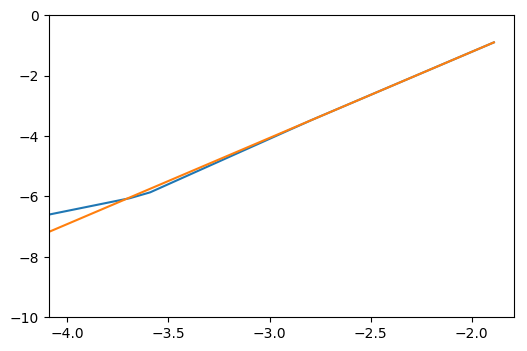

In [25]:
plt.xlim(np.log10(0.1*rho1), np.log10(10*rho2))
plt.ylim(-10, 0)
plt.plot(logrhopoints, logPpoints)
#plt.plot(logrhopoints, logp1only)
#plt.plot(logrhopoints, logp2only)
plt.plot(logrhopoints, logp3only)
plt.show()

In [26]:
logrhopointsCGS = np.arange(np.log10(1),np.log10(10*rho2*Density),0.1)

In [27]:
eospointsCGS = len(logrhopointsCGS)

In [28]:
logPpointsCGS = np.zeros(eospoints)
for i in range(0,eospoints):
    logPpointsCGS[i] = np.log10(Density*c**2*P_of_rho( pow(10.0,logrhopoints[i]), args))

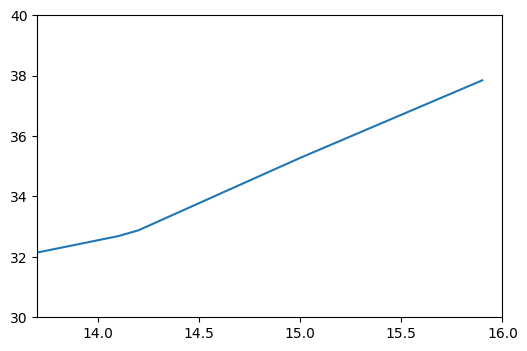

In [29]:
plt.xlim(np.log10(0.1*rho1*Density), np.log10(10*rho2*Density))
plt.ylim(30, 40)
plt.plot(logrhopointsCGS, logPpointsCGS)

## Choose the central density and find the central pressure

In [30]:
#rho_c = 1.444e-3
rho_c = 1.5*rho1
eps_c = eps_of_rho(rho_c, args2)
P_c = P_of_rho(rho_c, args)

display(rho_c, P_c)
display(eps_c, eps_of_P(P_c, args2))

0.0012179576759164205

0.00014657750856526157

0.001313483144404291

0.001313483144404291

## Define the system of ODEs to be solved

Define the system $ f(r, {\mathbf y} (r))$ of differential equations to be solved:
$$ f(r, {\mathbf y} (r)) = \frac{d}{dr} \begin{bmatrix} y_0(r)\\ y_1(r) \\ y_2(r) \end{bmatrix}
  = \frac{d}{dr} \begin{bmatrix} P(r)\\ m(r) \\ \nu(r) \end{bmatrix} = 
  \begin{bmatrix} -\frac{(\epsilon+P)(m+4\pi r^3P)}{r(r-2m)} \\  
                  4\pi r^2 \epsilon \\
                  \frac{2(m+4\pi r^3P)}{r(r-2m)} 
                  \end{bmatrix}$$

In [35]:
def f(r, y, args2):
    rhoL_3,rhoL_2,rhoL_1,rho0,rho1,rho2,KL_4,KL_3,KL_2,KL_1,K1,K2,K3,\
    GammaL_4,GammaL_3,GammaL_2,GammaL_1,Gamma1,Gamma2,Gamma3,\
    pL_3,pL_2, pL_1, p0, p1, p2,\
    alphaL_4, alphaL_3, alphaL_2, alphaL_1, alpha1, alpha2, alpha3 = args2
    
    eps = eps_of_P(y[0], args2) 
    
    return [ -( eps + y[0] )*( y[1] + 4.0*np.pi*pow(r,3.0)*y[0] )/( r*(r-2.0*y[1]) ), 
            
             4*np.pi*pow(r,2.0)*eps,
            
             2.0*( y[1] + 4.0*np.pi*pow(r,3.0)*y[0] )/( r*(r-2.0*y[1]) ) 
           ]

## Set the central value of $\nu_c$ and the starting values for the system of ODEs:

In [36]:
# set an arbitrary starting value for nu at the center
nu_c = -1.0

# set a safe max r, based on 4x radius of 1 Msun uniform density Newt. model
r_max = 4.0 * pow( 3.0/(4.0*np.pi*eps_c), 1.0/3.0)

# create an equidistant array of values for r
N = 25601
r = np.linspace(0.0, r_max, N)
dr = r[1] - r[0]

# compute P, m, nu at r=dr by Taylor expansion
P_1 =  P_c - (2.0*np.pi)*(eps_c+P_c)*(P_c+(1.0/3.0)*eps_c)*pow(dr,2.0)
m_1 =  (4.0/3.0)*np.pi*eps_c*pow(dr, 3.0)
nu_1 = nu_c + 4.0*np.pi*(P_c+(1.0/3.0)*eps_c)*pow(dr,2.0)

# set starting values at r=dr for numerical integration
y0 = [P_1, m_1, nu_1]


## Numerical solution

Define an instant of the numerical solution of the ODE system

In [37]:

solve = integrate.ode(f)
solve.set_integrator('lsoda', rtol=1e-12, atol=1e-50,ixpr=True);
solve.set_initial_value(y0, dr);
solve.set_f_params(args2);


Integrate from starting point to the surface (where $P=0$):

In [38]:
# create the solution vector
y = np.zeros((len(r), len(y0)))

# fill the solution vector with the values at the center
y[0,:] = [P_c, 0.0, nu_c]

# initialize counter
idx = 1

# integrate repeatedly to next grid point until P becomes zero
while solve.successful() and solve.t < r[-1] and solve.y[0]>0.0:
    
      y[idx, :] = solve.y
      solve.integrate(solve.t + dr)
      idx += 1

# last grid point with positive pressure
idxlast = idx-1 

# radius at last positive pressure grid point
R_last = r[idxlast]

# mass at last positive pressure grid point
Mass_last = y[idxlast][1]


Locate real radius by finding the location where h=1.0.

In [39]:
# use last 4 points to construct interpolant
r_data = np.zeros(4)
h_data = np.zeros(4)
eps_data = np.zeros(4)
rho_data = np.zeros(4)
P_data = np.zeros(4)
dmdr_data = np.zeros(4)

for i in range(idxlast-3,idxlast+1):
    r_data[i-idxlast+3] = r[i]
    eps_data[i-idxlast+3] = pow(y[i][0]/K1, 1.0/Gamma1) + y[i][0]/(Gamma1-1)
    rho_data[i-idxlast+3] = pow(y[i][0]/K1, 1.0/Gamma1)
    P_data[i-idxlast+3] = y[i][0]
    h_data[i-idxlast+3] = (eps_data[i-idxlast+3] + P_data[i-idxlast+3]) \
                           / rho_data[i-idxlast+3] -1.0
    dmdr_data[i-idxlast+3] = 4.0*np.pi*r[i]**2*eps_data[i-idxlast+3]

h_interp = PchipInterpolator(r_data, h_data)

# find the root using Brent's method
Radius = optimize.brentq( h_interp, r_data[0], r_data[3]+3*dr, xtol=1e-16 )

display(Radius)

ValueError: f(a) and f(b) must have different signs

Locate radius more accurately (to 4th-order) using a cubic Hermite interpolant of the specific enthalpy h-1.

In [40]:
def hHerm (r):
    r_last_1 = R_last-dr
    r_last = R_last
    w = (r-r_data[2])/dr
    m_last_1 = y[idxlast-1][1]
    m_last = y[idxlast][1]
    dhdr_last_1 = - (h_data[2]+1.0)*(m_last_1 + \
                            4.0*np.pi*r_last_1**3*y[idxlast-1][0])/ \
                           (r_last_1*(r_last_1-2.0*m_last_1))
    dhdr_last = - (h_data[3]+1.0)*(m_last + \
                           4.0*np.pi*r_last**3*y[idxlast][0])/ \
                           (r_last*(r_last-2.0*m_last))
    return (h_data[2]+1.0)*(2.0*pow(w,3.0)-3.0*pow(w,2.0)+1.0)+ \
                          (h_data[3]+1.0)*(2.0*pow(1.0-w,3.0)-3.0*pow(1.0-w,2.0)+1.0) \
                          + ( dhdr_last_1*(pow(w,3.0)-2.0*pow(w,2.0)+w) - \
                           dhdr_last*(pow(1-w,3.0)-2.0*pow(1-w,2.0)+1-w))*dr -1.0

In [41]:
Radius = optimize.brentq( hHerm, r_data[0], r_data[3]+3*dr, xtol=1e-16 )
display(Radius)

8.00731497245147

Correct mass by adding last missing trapezoid:

In [42]:
Mass = Mass_last + 0.5*4*np.pi*R_last**2*eps_data[3]*(Radius-R_last)
display(Mass)

1.1323227474901163

In [43]:
dmdr_interp_pchip = PchipInterpolator(r_data, dmdr_data)
dmdr_midpoint = dmdr_interp_pchip((R_last+Radius)/2)
Dmass_simps = (1.0/3.0)*(Radius-R_last)/2*(dmdr_interp_pchip(R_last)+4.0*dmdr_midpoint+dmdr_interp_pchip(Radius))

Mass = Mass_last + Dmass_simps

display(Mass)

1.1323227474901469

Construct table with main solution variables:

In [44]:
values = np.zeros((idxlast+1, 9)) 

for i in range(0,idxlast+1): 
    values[i][0] = r[i]
    values[i][1] = rho_of_P(y[i][0], args) # rho
    values[i][2] = eps_of_P(y[i][0], args2) # epsilon
    values[i][3] = y[i][0]   # P
    values[i][4] = y[i][1]   # m
    values[i][5] = y[i][2]   # nu (arbitrary)

# lambda
values[0][6] = 0.0
for i in range(1,idxlast+1):     
    values[i][6] = - np.log(1.0-2.0*y[i][1]/r[i])
    
values[:, 7] = (values[:, 2] + values[:, 3])/values[:, 1]  # h
values[:, 8] = np.gradient(values[:, 3],dr,edge_order=2)/(values[:,2] +values[:,3] )  
                                                                # (e+P)^{-1} dP/dr

Match $\nu$ at the surface, using Schwarzshild vacuum solution:

In [45]:
# arbitrary nu at the surface
nu_s_old = y[idxlast][2]

# correct nu at the surface
nu_s = np.log(1.0-2.0*Mass/Radius)

# shift nu inside star by difference
values[:, 5] = values[:, 5] + (-nu_s_old + nu_s)

Compute baryon mass and alternative expression for gravitational mass:

In [46]:
# construct radius array and integrands for baryon and alternative mass integration

rint = np.zeros(idxlast+1)
m0int = np.zeros(idxlast+1)
mint_alt = np.zeros(idxlast+1)

# fill radius array and integrands 

for i in range(0,idxlast+1): 
    rint[i] = values[i][0]
    m0int[i] = 4.0*np.pi*pow(rint[i],2.0)*np.exp(values[i][6]/2.0)*values[i][1]
    mint_alt[i] = 4.0*np.pi*pow(rint[i],2.0)*np.exp((values[i][5]+values[i][6])/2.0) \
                  *(values[i][2]+3.0*values[i][3])

# integrate using Simpson's method
M0_last = integrate.simps( m0int, dx=dr)
M_alt_last = integrate.simps( mint_alt, dx=dr, even='last')

# correct M0 and M_alt by adding last trapezoid
M0 = M0_last + 0.5*4.0*np.pi*R_last**2*np.exp(values[idxlast][6]/2.0) \
                      *values[idxlast][1]*(Radius-R_last)

M_alt = M_alt_last + 0.5*4.0*np.pi*R_last**2* np.exp((values[idxlast][5]
                            +values[idxlast][6])/2.0)*(values[idxlast][2] \
                                +3.0*values[idxlast][3]) *(Radius-R_last)

# compute relative difference between mass and alt. mass
M_reldiff = (Mass-M_alt)/Mass


# Main results

In [47]:
N_gridpoints = idxlast+1

print('Number of grid points =', N_gridpoints)
print('rho_c =', rho_c)
print('epsilon_c =', eps_c)
print('P_c =', P_c)
print('dr =', dr)
print('Radius of last grid point =', R_last)
print('Extrapolated Radius at zero pressure =', '%.16f'% Radius)
print('Baryon Mass =', M0)
print('Gravitational Mass =', '%.16f'% Mass)
print('Alternative Mass =', M_alt)
print('Rel. diff. in Mass =', M_reldiff)

Number of grid points = 9048
rho_c = 0.0012179576759164205
epsilon_c = 0.001313483144404291
P_c = 0.00014657750856526157
dr = 0.000885079581016
Radius of last grid point = 8.00731496945
Extrapolated Radius at zero pressure = 8.0073149724514696
Baryon Mass = 1.22210937471
Gravitational Mass = 1.1323227474901469
Alternative Mass = 1.13232272777
Rel. diff. in Mass = 1.7415123853e-08


# Figures

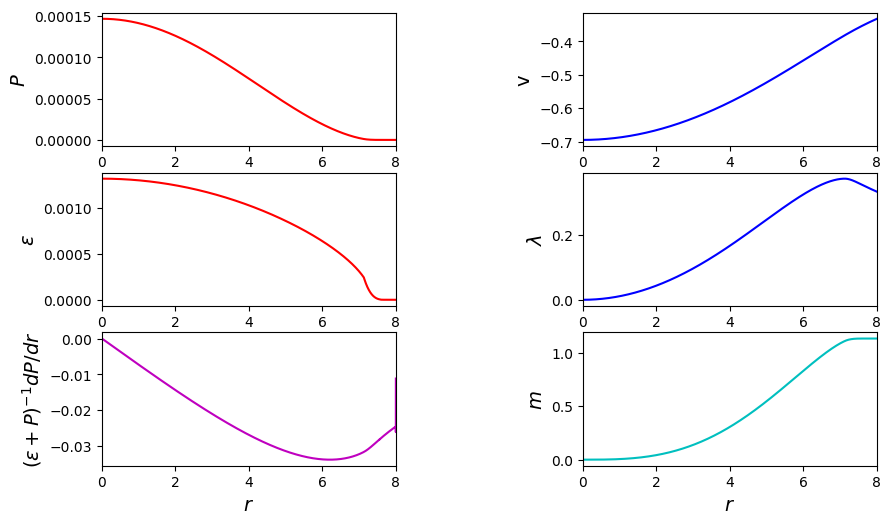

In [48]:
fig = plt.figure(figsize=(10, 6))
ax1 = plt.subplot2grid((3, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 5), (1, 0), colspan=2)
ax3 = plt.subplot2grid((3, 5), (2, 0), colspan=2)
ax4 = plt.subplot2grid((3, 5), (0, 3), colspan=2)
ax5 = plt.subplot2grid((3, 5), (1, 3), colspan=2)
ax6 = plt.subplot2grid((3, 5), (2, 3), colspan=2)

ax1.plot(values[:, 0], values[:, 3], 'r')
ax1.set_ylabel('$P$', fontsize=14)
ax1.set_xlim((0,R_last))

ax2.plot(values[:, 0], values[:, 2], 'r')
ax2.set_ylabel('$\epsilon$', fontsize=14)
ax2.set_xlim((0, R_last));

ax3.plot(values[:, 0], values[:, 8], 'm')
ax3.set_xlabel('$r$', fontsize=14)
ax3.set_ylabel('$(\epsilon+P)^{-1}dP/dr$', fontsize=14)
ax3.set_xlim((0, R_last));

ax4.plot(values[:, 0], values[:, 5], 'b')
ax4.set_ylabel('v', fontsize=14)
ax4.set_xlim((0, R_last))

ax5.plot(values[:, 0], values[:, 6], 'b')
ax5.set_ylabel('$\lambda$', fontsize=14)
ax5.set_xlim((0, R_last));

ax6.plot(values[:, 0], values[:, 4], 'c')
ax6.set_ylabel('$m$', fontsize=14)
ax6.set_xlim((0, R_last));
ax6.set_xlabel('$r$', fontsize=14)

plt.show()

# Convert to CGS

In [49]:
c=2.9979e10
G=6.67408e-8
Msun=1.989e33
Length = G*Msun/c**2
Time = Length/c
Density = Msun/Length**3
dr_CGS = dr*Length
#K_CGS = K * c**2 * pow(Length**3/Msun, Gamma-1)
print('Number of grid points =', N_gridpoints)
#print('K =', K_CGS)
print('rho_c =', rho_c*Density)
print('epsilon_c/c^2 =', eps_c*Density)
print('epsilon_c =', eps_c*Density*c**2)
print('P_c =', P_c*Density*c**2)
print('dr =', dr_CGS)
print('Radius of last grid point =', R_last*Length)
print('Extrapolated Radius at zero pressure =', Radius*Length)
print('Baryon Mass =', M0*Msun)
print('Gravitational Mass =', Mass*Msun)
print('Alternative Mass =', M_alt*Msun)
print('Rel. diff. in Mass =', M_reldiff)

Number of grid points = 9048
rho_c = 751780850440907.2
epsilon_c/c^2 = 810743669394811.1
epsilon_c = 7.286481229698507e+35
P_c = 8.131313061814282e+34
dr = 130.729689162
Radius of last grid point = 1182711.49785
Extrapolated Radius at zero pressure = 1182711.4982895614
Baryon Mass = 2.43077554629e+33
Gravitational Mass = 2.25218994476e+33
Alternative Mass = 2.25218990554e+33
Rel. diff. in Mass = 1.7415123853e-08


In [50]:
values_CGS = np.zeros((idxlast+1, 9)) 

values_CGS[:, 0] = values[:, 0] * Length
values_CGS[:, 1] = values[:, 1] * Density  # rho
values_CGS[:, 2] = values[:, 2] * Density*c**2  # epsilon
values_CGS[:, 3] = values[:, 3] * Density*c**2  # P
values_CGS[:, 4] = values[:, 4] * Msun  # m
values_CGS[:, 5] = values[:, 5]         # nu
values_CGS[:, 6] = values[:, 6]         # lambda
values_CGS[:, 7] = values[:, 7] * c**2  # h
values_CGS[:, 8] = values[:, 8] / Length   # (epsilon+P)^{-1} dP/dr

# Write output files

In [51]:
np.savetxt('TOV_output.dat', values)
np.savetxt('TOV_output_CGS.dat', values_CGS)

# Convergence study

Using 11 different grid sizes (doubling the number of points each time), one can show the 4th-order convergence of the code to machine accuracy. Notice that the order of covergence is basically set by the Taylor expansion at the center, since the Runge-Kutta integration that follows up to the surface is a highly-accurate, adaptive step-size method. The mass contained between the last grid point with positive pressure and the true radius where the pressure vanishes is added by a trapezoidal rule, but this does not influence significantly the order of convergence (but using the cubic Hermite interpolation to locate the true radius is critical for maintaining an overall 4th-order of convergence). 

In [22]:
#different number of grid points used
Npoints = (51, 101, 201, 401, 801, 1601,  3201, 6401, 12801, 25601, 51201) 

#corresponding radii
Rpoints = (9.5856078811896612, 9.5854362495120196, 9.5854295071567517, 
           9.5854293025063289, 9.5854292773890855, 9.5854292765629605, 
           9.5854292764823121, 9.5854292764841311, 9.5854292764900038, 
           9.5854292764910038, 9.5854292764934073)

#corresponding masses
Mpoints = (1.4001068618325290, 1.4002041973306332, 1.4002083439839288, 
           1.4002084210000705, 1.4002084365940546, 1.4002084368655729, 
           1.4002084369184078, 1.4002084369019683, 1.4002084369033669, 
           1.4002084369046766, 1.4002084369042820)


In [23]:
Nconv = 10
Ndiffpoints = np.zeros(Nconv)
Mdiffpoints = np.zeros(Nconv)
Rdiffpoints = np.zeros(Nconv)
Mdiffpoints_abs = np.zeros(Nconv)
Rdiffpoints_abs = np.zeros(Nconv)

for i in range(0,Nconv):
    Ndiffpoints[i] = Npoints[i]
    Mdiffpoints[i] = (Mpoints[Nconv]-Mpoints[i])/Mpoints[Nconv]
    Rdiffpoints[i] = (Rpoints[Nconv]-Rpoints[i])/Rpoints[Nconv]
    Mdiffpoints_abs[i] = np.abs(Mpoints[Nconv]-Mpoints[i])/Mpoints[Nconv]
    Rdiffpoints_abs[i] = np.abs(Rpoints[Nconv]-Rpoints[i])/Rpoints[Nconv]


In [24]:
display(Rdiffpoints)
display(Mdiffpoints)

array([ -1.86329366e-05,  -7.27460233e-07,  -2.40639556e-08,
        -2.71379829e-09,  -9.34416365e-11,  -7.25614368e-12,
         1.15749900e-12,   9.67732915e-13,   3.55070139e-13,
         2.50735855e-13])

array([  7.25428223e-05,   3.02781610e-06,   6.63618007e-08,
         1.13584600e-08,   2.21558013e-10,   2.76451955e-11,
        -1.00883635e-11,   1.65240026e-12,   6.53506859e-13,
        -2.81796090e-13])

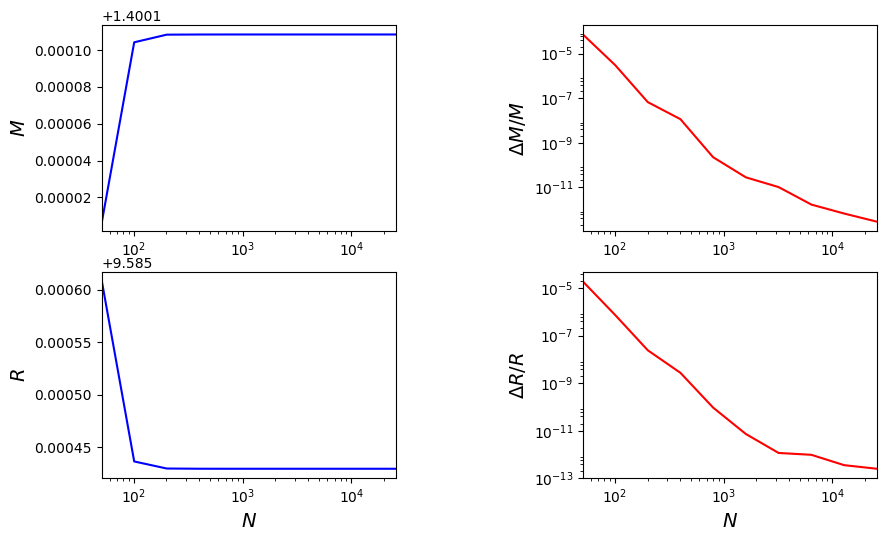

In [25]:
fig = plt.figure(figsize=(10, 6))
ax1 = plt.subplot2grid((2, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 5), (1, 0), colspan=2)
ax3 = plt.subplot2grid((2, 5), (0, 3), colspan=2)
ax4 = plt.subplot2grid((2, 5), (1, 3), colspan=2)

ax1.plot(Npoints, Mpoints, 'b')
ax1.set_xscale("log")
ax1.set_ylabel('$M$', fontsize=14)
ax1.set_xlim((0,Npoints[Nconv-1]))

ax2.plot(Npoints, Rpoints, 'b')
ax2.set_xscale("log")
ax2.set_ylabel('$R$', fontsize=14)
ax2.set_xlim((0,Npoints[Nconv-1]))
ax2.set_xlabel('$N$', fontsize=14)

ax3.plot(Ndiffpoints, Mdiffpoints_abs, 'r')
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_ylabel('$\Delta M / M$', fontsize=14)
ax3.set_xlim((0,Npoints[Nconv-1]))

ax4.plot(Ndiffpoints, Rdiffpoints_abs, 'r')
ax4.set_xscale("log")
ax4.set_yscale("log")
ax4.set_ylabel('$\Delta R / R$', fontsize=14)
ax4.set_xlim((0,Npoints[Nconv-1]))
ax4.set_xlabel('$N$', fontsize=14)

plt.show()

Average convergence order:

In [26]:
( np.log10(Mdiffpoints_abs[5])-np.log10(Mdiffpoints_abs[0]))/( np.log10(Ndiffpoints[5])
                                                      - np.log10(Ndiffpoints[0]))

-4.2884046348423377

In [27]:
( np.log10(Rdiffpoints_abs[5])-np.log10(Rdiffpoints_abs[0]))/( np.log10(Ndiffpoints[5])
                                                      - np.log10(Ndiffpoints[0]))

-4.282125094503952

In [28]:
np.log2( (Mpoints[1]- Mpoints[0] )/( Mpoints[2] - Mpoints[1]))

4.552946716872813

In [29]:
np.log2( (Rpoints[1]- Rpoints[0] )/( Rpoints[2] - Rpoints[1]))

4.6699193941600026